In [1]:
# use geo_env_2022
import os
import numpy as np
import pandas as pd # original 1.2.3
import geopandas as gpd
from shapely.geometry import Point
import pickle
import urllib.request

import matplotlib.pyplot as plt

In [2]:
def get_prio_shape():

    location = '/home/simon/Documents/Bodies/data/PRIO'
    path_prio = location + '/priogrid_shapefiles.zip'

    if os.path.isfile(path_prio) == True:
        
        print('File already downloaded')
        prio_grid = gpd.read_file('zip://' + path_prio)

    else:
        print('Beginning file download PRIO...')
        url_prio = 'http://file.prio.no/ReplicationData/PRIO-GRID/priogrid_shapefiles.zip'

        urllib.request.urlretrieve(url_prio, path_prio)
        prio_grid = gpd.read_file('zip://' + path_prio)

    return prio_grid

In [3]:
def get_gwno():

    location = '/home/simon/Documents/Bodies/data/PRIO'
    #path_gwno = location + '/PRIO-GRID Yearly Variables for 2003-2009 - 2022-06-16.csv' #https://grid.prio.org/#/download # need to figrue out the API
    path_gwno = location + '/PRIO-GRID Yearly Variables for 1989-2014 - 2022-06-16.csv' #https://grid.prio.org/#/download # need to figrue out the API

    # why not just go 1989 - 2019 like ucdp...

    gwno = pd.read_csv(path_gwno)

    return gwno



In [4]:
def get_ucdp():
    location = '/home/simon/Documents/Bodies/data/UCDP' 
    path_ucdp = location + "/ged201-csv.zip"
    
    if os.path.isfile(path_ucdp) == True:
        print('file already downloaded')
        ucdp = pd.read_csv(path_ucdp)


    else: 
        print('Beginning file download UCDP...')

        url_ucdp = 'https://ucdp.uu.se/downloads/ged/ged201-csv.zip'
    
        urllib.request.urlretrieve(url_ucdp, path_ucdp)
        ucdp = pd.read_csv(path_ucdp)

    return ucdp

In [5]:
def add_month_id(ucdp): # you could also do a week_id....

    ucdp_tmp1 = ucdp.copy()

    ucdp_tmp1['year_months_start'] = ucdp_tmp1['date_start'].str.slice(start = 0, stop = 7) # Date YYYY-MM-DD
    ucdp_tmp1['year_months_end'] = ucdp_tmp1['date_start'].str.slice(start = 0, stop = 7) # Date YYYY-MM-DD


    mask1 = (ucdp_tmp1['year'] != ucdp_tmp1['year_months_start'].str.slice(start = 0, stop = 4).astype(int))
    mask2 = (ucdp_tmp1['year'] != ucdp_tmp1['year_months_end'].str.slice(start = 0, stop = 4).astype(int))

    # correction. Note that end and start year for the four entries that is corrected is the same.
    ucdp_tmp1.loc[mask1 | mask2, 'year'] = ucdp_tmp1.loc[mask1 | mask2,'year_months_start'].str.slice(start = 0, stop = 4).astype(int)

    ds_uniques = ucdp_tmp1['date_start'].str.slice(start = 0, stop = 7).unique()
    de_uniques = ucdp_tmp1['date_end'].str.slice(start = 0, stop = 7).unique() # do you need both?

    months_unique = np.union1d(ds_uniques, de_uniques)
    months_unique.sort()

    month_id = np.arange(109, months_unique.shape[0] + 109, 1) # this makes sure the month_id matches that of ViWES replication data. Just in case.

    month_df = pd.DataFrame({'month_id' : month_id, 'year_months_start' : months_unique, 'year_months_end' : months_unique})

    # I checked. There is no instance where the month id will differ if we take start or end.
    ucdp_tmp2 = ucdp_tmp1.merge(month_df[['month_id', 'year_months_start']], how = 'outer', on= 'year_months_start')

    return(ucdp_tmp2)

In [6]:
def trim_ucdp(ucdp_monthly):

    ucdp_slim = ucdp_monthly[['country','year', 'month_id', 'year_months_start', 'priogrid_gid','best','low','high']].copy()
    ucdp_gid = ucdp_slim.groupby(by=['priogrid_gid','month_id', 'year_months_start', 'year','country']).sum().reset_index() # so right now it is monthly units. you can change this..
    ucdp_gid.rename(columns={'priogrid_gid':'gid'}, inplace=True)

    ucdp_gid['log_best'] = np.log(ucdp_gid['best'] +1)
    ucdp_gid['log_low'] = np.log(ucdp_gid['low'] +1)
    ucdp_gid['log_high'] = np.log(ucdp_gid['high'] +1)

    return(ucdp_gid)

In [7]:
def add_years(ucdp, world_grid):

    diff = ucdp['year'].max() - world_grid['year'].max()

    subset_list = []

    for i in np.arange(1, diff+1, 1):

        subset = world_grid[world_grid['year'] == world_grid['year'].max()].copy()
        subset['year'] = world_grid['year'].max() + i

        subset_list.append(subset)

    new_years = pd.concat(subset_list)
    world_grid_all_years = pd.concat([world_grid, new_years])

    return world_grid_all_years

In [8]:
def combine_UCDP_PRIO(ucdp_gid, world_grid_all_years):

    month = [str(i).zfill(2) for i in np.arange(1,13,1)]
    world_grid_all_years.loc[:,'month'] = world_grid_all_years.apply(lambda _: month, axis=1)
    world_grid_monthly = world_grid_all_years.explode('month')

    world_grid_monthly['year_months_start'] = world_grid_monthly['year'].astype(str) + '-' +  world_grid_monthly['month'].astype(str)

    #ucdp_cliped = ucdp_gid[ucdp_gid['year']<2015].copy()# Could also just expand world_grid_monhtly but I do not need these values anyway (for now)..

    combined_df = world_grid_monthly.merge(ucdp_gid, how = 'left', on = ['gid', 'year_months_start', 'year']) # month id needs to be made after..
    combined_df.loc[:, ['best', 'low', 'high', 'log_best', 'log_low', 'log_high']] = combined_df.loc[:, ['best', 'low', 'high', 'log_best', 'log_low', 'log_high']].fillna(0)

    month_id_dict = dict(zip(ucdp_gid['year_months_start'],ucdp_gid['month_id']))
    combined_df['month_id'].fillna(combined_df['year_months_start'].map(month_id_dict), inplace = True)
    combined_df['month_id'] = combined_df['month_id'].astype(int)

    #combined_df['gwno'] = combined_df['gwno'].astype(int)
    # Does not really work...
    #contry_dict = dict(zip(combined_df.loc[combined_df['country'].notna(), 'country'].unique(), combined_df.loc[combined_df['country'].notna(), 'gwno'].unique()))
    #combined_df['country'].fillna(combined_df['gwno'].map(contry_dict), inplace = True)

    combined_df.drop(columns= ['country'], inplace = True)

    return(combined_df)

In [9]:
prio_grid = get_prio_shape()
gwno = get_gwno()
world_grid = prio_grid.merge(gwno, how = 'right', on = 'gid') # if you just merge this on outer I think you get the full grid needed for R-UNET

ucdp = get_ucdp()
ucdp_monthly = add_month_id(ucdp)
ucdp_gid = trim_ucdp(ucdp_monthly)

world_grid_all_years = add_years(ucdp, world_grid)

combined_df = combine_UCDP_PRIO(ucdp_gid, world_grid_all_years)

File already downloaded
file already downloaded


/tmp/ipykernel_277292/3991126561.py:7: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  ucdp = pd.read_csv(path_ucdp)


In [10]:
data_dir = '/home/simon/Documents/Bodies/data/OD_dataframes_compiled/'

with open(f'{data_dir}df_ucdp_prio.pkl', 'wb') as file:
    pickle.dump(combined_df, file)

In [11]:
# Check:

for y in sorted(combined_df['year'].unique()):
    array = combined_df[combined_df['year'] == y]['month_id'].unique()
    print(f'{y}: {array}')

for y in sorted(ucdp_gid['year'].unique())[:26]:
    array = sorted(ucdp_gid[ucdp_gid['year'] == y]['month_id'].unique())
    print(f'{y}: {array}')

1989: [109 110 111 112 113 114 115 116 117 118 119 120]
1990: [121 122 123 124 125 126 127 128 129 130 131 132]
1991: [133 134 135 136 137 138 139 140 141 142 143 144]
1992: [145 146 147 148 149 150 151 152 153 154 155 156]
1993: [157 158 159 160 161 162 163 164 165 166 167 168]
1994: [169 170 171 172 173 174 175 176 177 178 179 180]
1995: [181 182 183 184 185 186 187 188 189 190 191 192]
1996: [193 194 195 196 197 198 199 200 201 202 203 204]
1997: [205 206 207 208 209 210 211 212 213 214 215 216]
1998: [217 218 219 220 221 222 223 224 225 226 227 228]
1999: [229 230 231 232 233 234 235 236 237 238 239 240]
2000: [241 242 243 244 245 246 247 248 249 250 251 252]
2001: [253 254 255 256 257 258 259 260 261 262 263 264]
2002: [265 266 267 268 269 270 271 272 273 274 275 276]
2003: [277 278 279 280 281 282 283 284 285 286 287 288]
2004: [289 290 291 292 293 294 295 296 297 298 299 300]
2005: [301 302 303 304 305 306 307 308 309 310 311 312]
2006: [313 314 315 316 317 318 319 320 321 322 3

In [12]:
combined_df

,gid,xcoord,ycoord,col,row,geometry,year,gwno,month,year_months_start,month_id,best,low,high,log_best,log_low,log_high
0,49182,-69.25,-55.75,222,69,"POLYGON ((-69.50000 -56.00000, -69.50000 -55.5...",2003,155.0,01,2003-01,277,0.0,0.0,0.0,0.0,0.0,0.0
1,49182,-69.25,-55.75,222,69,"POLYGON ((-69.50000 -56.00000, -69.50000 -55.5...",2003,155.0,02,2003-02,278,0.0,0.0,0.0,0.0,0.0,0.0
2,49182,-69.25,-55.75,222,69,"POLYGON ((-69.50000 -56.00000, -69.50000 -55.5...",2003,155.0,03,2003-03,279,0.0,0.0,0.0,0.0,0.0,0.0
3,49182,-69.25,-55.75,222,69,"POLYGON ((-69.50000 -56.00000, -69.50000 -55.5...",2003,155.0,04,2003-04,280,0.0,0.0,0.0,0.0,0.0,0.0
4,49182,-69.25,-55.75,222,69,"POLYGON ((-69.50000 -56.00000, -69.50000 -55.5...",2003,155.0,05,2003-05,281,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24112858,249344,-68.25,83.25,224,347,"POLYGON ((-68.50000 83.00000, -68.50000 83.500...",2019,20.0,08,2019-08,476,0.0,0.0,0.0,0.0,0.0,0.0
24112859,249344,-68.25,83.25,224,347,"POLYGON ((-68.50000 83.00000, -68.50000 83.500...",2019,20.0,09,2019-09,477,0.0,0.0,0.0,0.0,0.0,0.0
24112860,249344,-68.25,83.25,224,347,"POLYGON ((-68.50000 83.00000, -68.50000 83.500...",2019,20.0,10,2019-10,478,0.0,0.0,0.0,0.0,0.0,0.0
24112861,249344,-68.25,83.25,224,347,"POLYGON ((-68.50000 83.00000, -68.50000 83.500...",2019,20.0,11,2019-11,479,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.to_crs(combined_df.crs)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


109: 1989-01


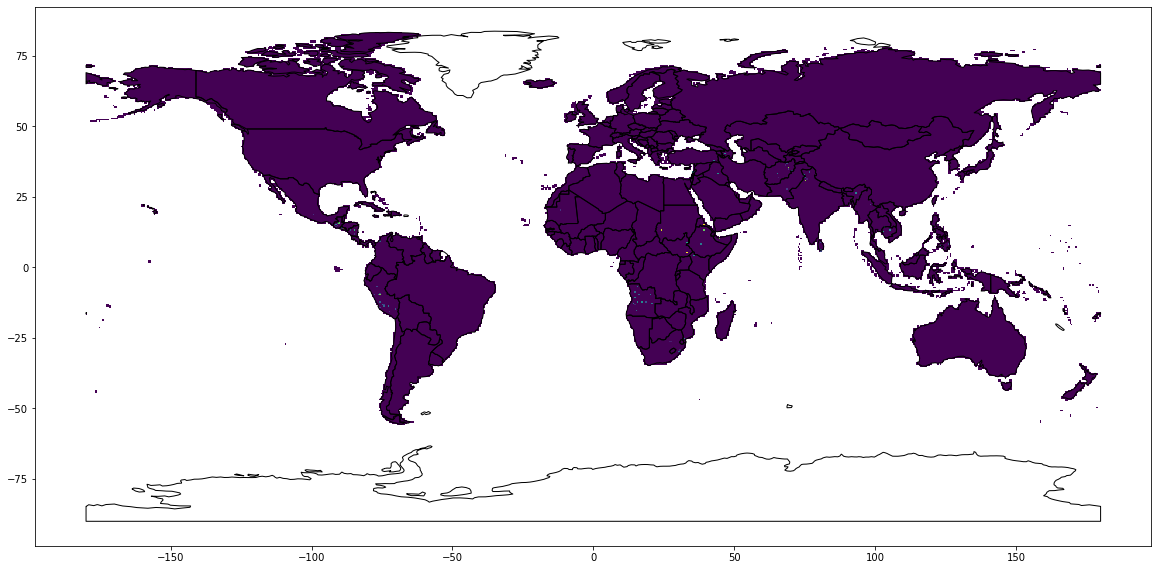

110: 1989-02


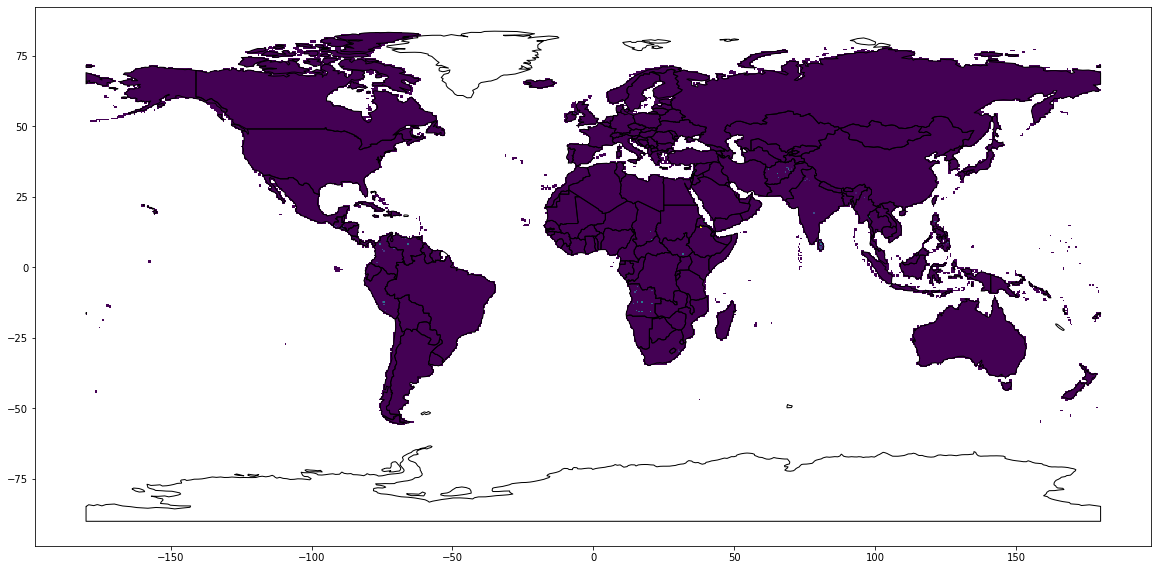

111: 1989-03


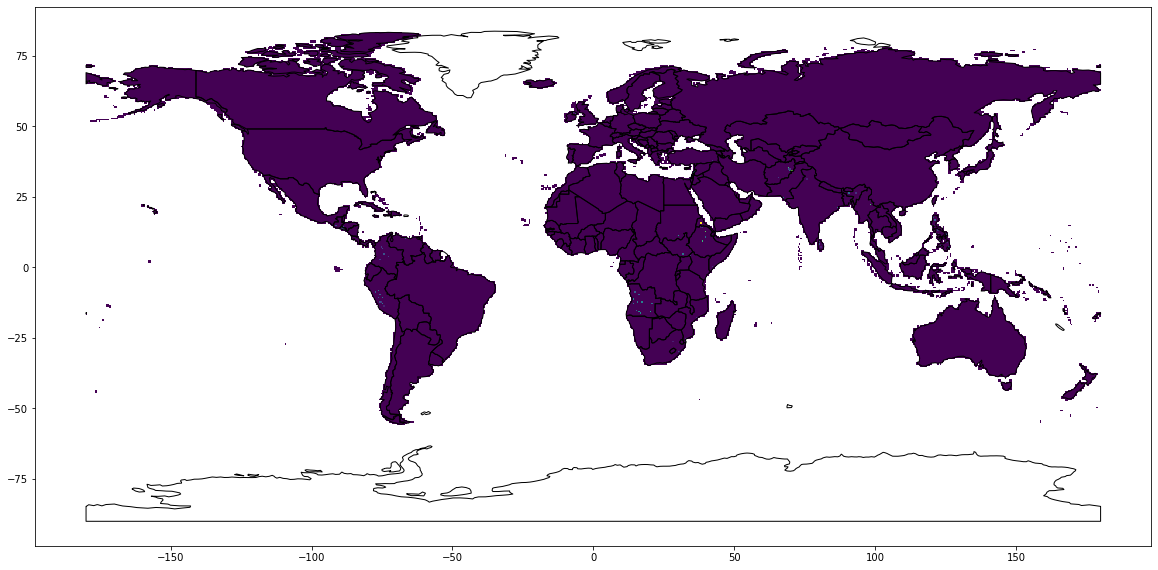

112: 1989-04


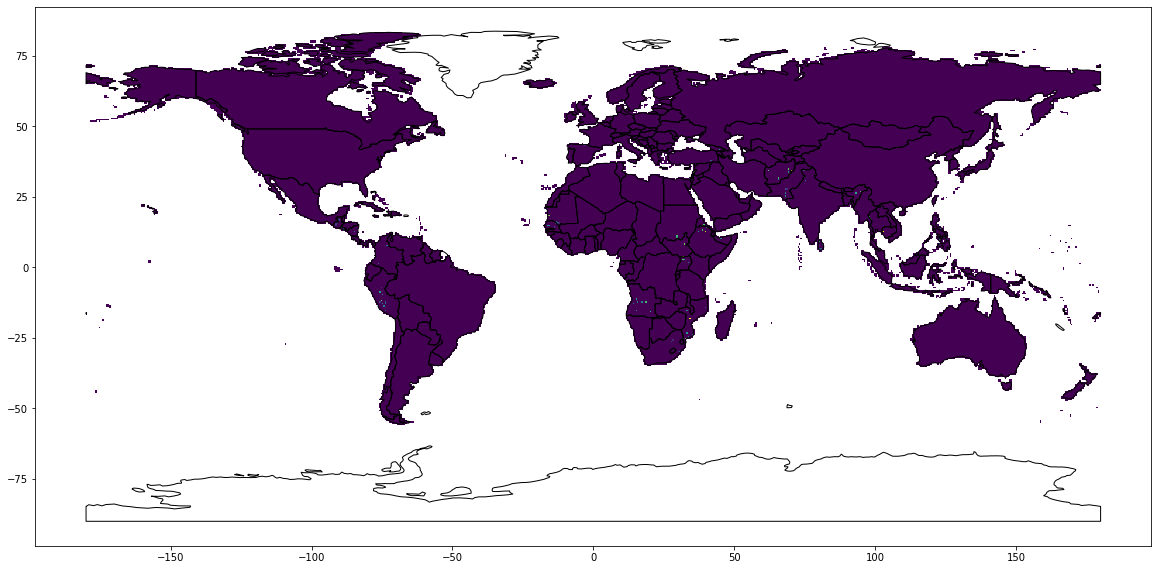

113: 1989-05


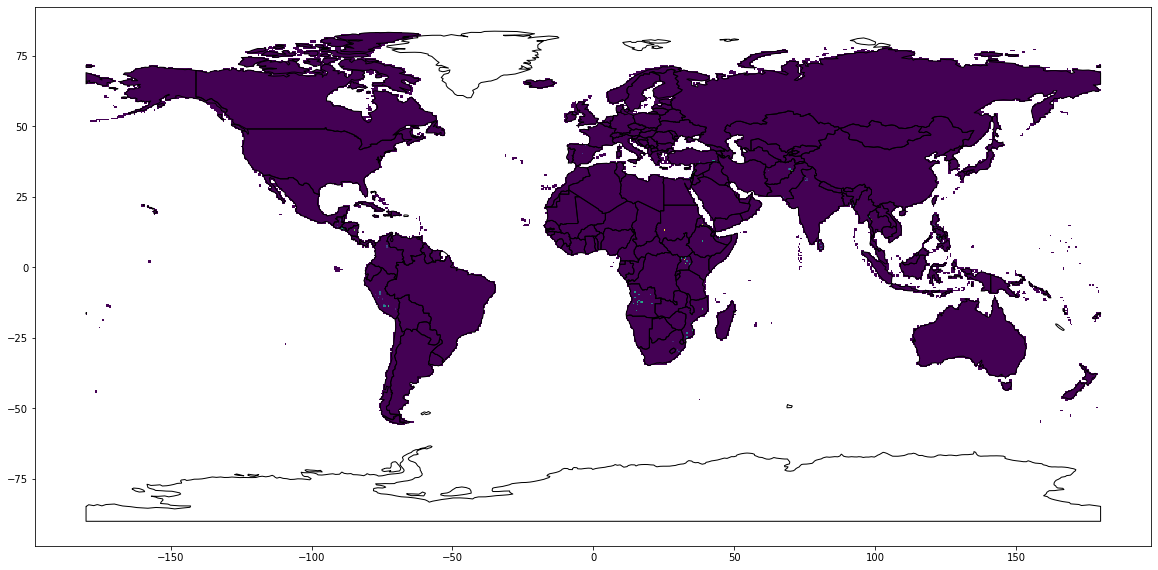

In [15]:
for i in sorted(combined_df['month_id'].unique())[0:5]:

    print(f"{i}: {combined_df[combined_df['month_id'] == i]['year_months_start'].unique().item()}")
    fig, ax = plt.subplots(figsize = (20,20))
    combined_df[combined_df['month_id'] == i].plot(ax=ax, column = 'log_best')
    world.plot(facecolor='none', edgecolor='black', ax=ax)
    plt.show()